In [771]:
import numpy as np 
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import random

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, Dense, Dropout, LeakyReLU, UpSampling2D, concatenate
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

In [772]:
# dataset : https://www.kaggle.com/dansbecker/cityscapes-image-pairs
data_dir = "C:\\Users\\USER\\kaggle\\cityscapes_data"
train_dir = os.path.join(data_dir,"train")
val_dir = os.path.join(data_dir,"val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
width, height, classes, batch_size = 256,256,13,10
print(len(train_fns),len(val_fns))

2975 500


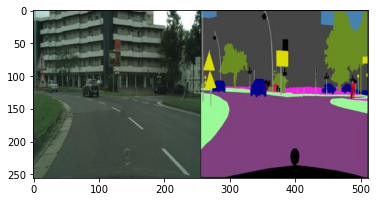

In [929]:
sample_image = os.path.join(train_dir,train_fns[0])
sample_image = Image.open(sample_image).convert("RGB")
plt.imshow(sample_image)

(256, 512, 3)
(256, 256, 3) (256, 256, 3)
0 255 0 255


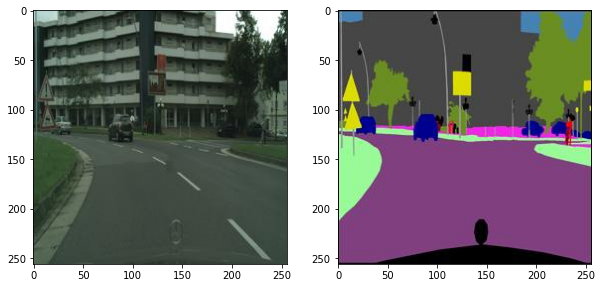

In [774]:
sample_image = np.array(sample_image)
print(sample_image.shape)
image, mask = sample_image[:,:256],sample_image[:,256:]
print(image.shape, mask.shape)
print(image.min(),image.max(),mask.min(),mask.max())
fig,axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(image)
axes[1].imshow(mask)

In [775]:
def divide_img(img):
    img = np.array(img)
    image = img[:,:256]
    mask = img[:,256:]
    return image, mask

In [815]:
real_img = []
mask_img = []

In [816]:
for i in range(len(train_fns)):
    sample_image = os.path.join(train_dir,train_fns[i])
    sample_image = Image.open(sample_image).convert("RGB")
    cityscape, label= divide_img(sample_image)
    real_img.insert(i,cityscape)
    mask_img.insert(i,label)

In [978]:
colors = []
for i in np.random.choice(len(train_fns),10): 
    colors.append(mask_img[i].reshape(-1,3))
colors = np.array(colors)
print(colors.shape)
colors = colors.reshape(-1,3)
print(colors.shape)

(10, 65536, 3)
(655360, 3)


In [1097]:
km = KMeans(13)
km.fit(colors)

KMeans(n_clusters=13)

In [1098]:
print(km.cluster_centers_)

[[ 83.01625141   3.38398845  74.07313133]
 [106.88990483 140.18192449  36.77622691]
 [128.15951638  62.91103777 126.87000313]
 [  4.76332021   3.23744148   7.05079141]
 [235.97293031  40.8163523  224.42478889]
 [ 70.48906344  70.12116273  69.42762155]
 [ 73.41495235 129.50261506 175.70966992]
 [211.79429776  22.02779545  57.76029903]
 [  3.78224193   1.9471692  135.81363219]
 [134.84306015 115.37644868 104.85871965]
 [216.16610738 196.42980984  42.84535794]
 [160.60984747 243.70430827 156.77950227]
 [201.32821851 153.49884916 168.77198097]]


In [1099]:
def FindClassLoc(mask):  
    s = mask.reshape(-1,3)
    s = km.predict(s)
    s = s.reshape(256,256)
    n = len(km.cluster_centers_)
    cls = np.zeros((256,256,n))
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        cls[:,:,i] = m
    return cls                

In [1100]:
def MaskOwnColor(cls):
    colors = [(255,0,0), (0,255,0), (0,0,255),
                 (255,255,0), (255,0,255), (0,255,255),
                 (255,255,255), (200,50,0),(50,200,0),
                 (50,0,200), (200,200,50), (0,50,200),
                 (0,200,50), (0,0,0)]
    nimg = np.zeros((256,256,3))
    for i in range(cls.shape[2]):
        c = cls[:,:,i]
        col = colors[i]

        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

In [1208]:
def find_class(class_num,mask):
    s = mask.reshape(-1,3)
    s = km.predict(s)
    s = s.reshape(256,256)
    m = np.copy(s)
    m[m!=class_num] = 0
    m[m!=0] = 1
    m = (m)
    return m

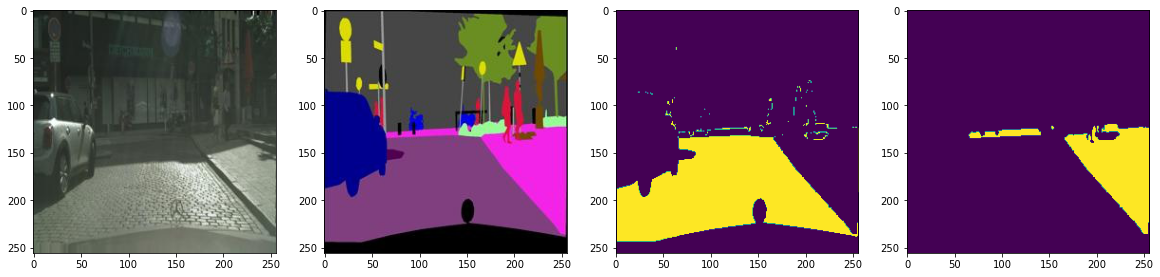

In [1211]:
fig,axes = plt.subplots(1,4,figsize=(5*4,5))
i = 232
axes[0].imshow(real_img[i])
axes[1].imshow(mask_img[i])
axes[2].imshow(find_class(2,mask_img[i]))
axes[3].imshow(find_class(4,mask_img[i]))
# 2:도로 4: 인도

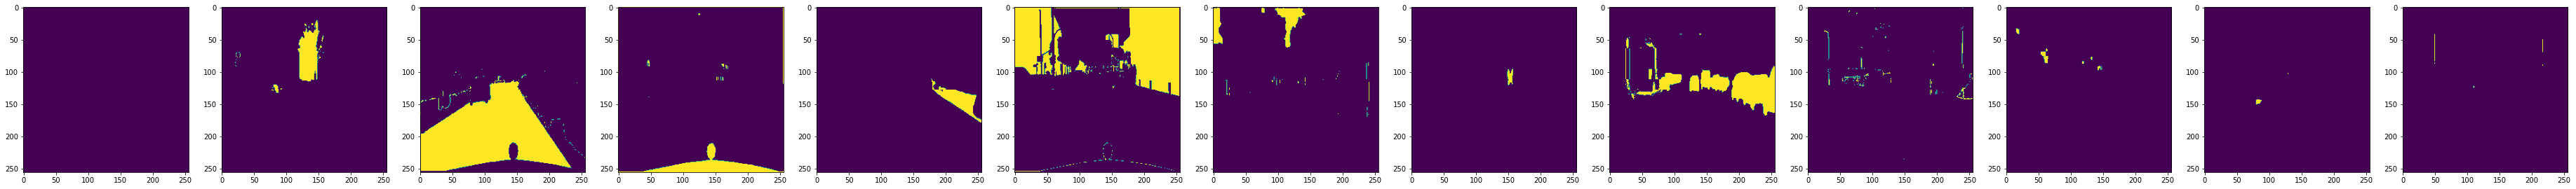

In [1227]:
fig,axes = plt.subplots(1,13,figsize=(5*13,5))
plt.imshow()
for i in range(0,13):
    axes[i].imshow(find_class(i,mask_img[i]))

In [ ]:
real, mask = divide_img(sample_image)
cls = FindClassLoc(mask)
label = MaskOwnColor(cls)
fig,axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(real)
axes[1].imshow(mask)
axes[2].imshow(label)

In [1212]:
train_real = []
train_mask = []
train_label =[]

for i in range(len(train_fns)):
    sample_image = os.path.join(train_dir,train_fns[i])
    sample_image = Image.open(sample_image).convert("RGB")
    real, mask= divide_img(sample_image)
    cls = FindClassLoc(mask)
    label = MaskOwnColor(cls)
    train_real.insert(i,real)
    train_mask.insert(i,mask)
    train_label.insert(i,label)

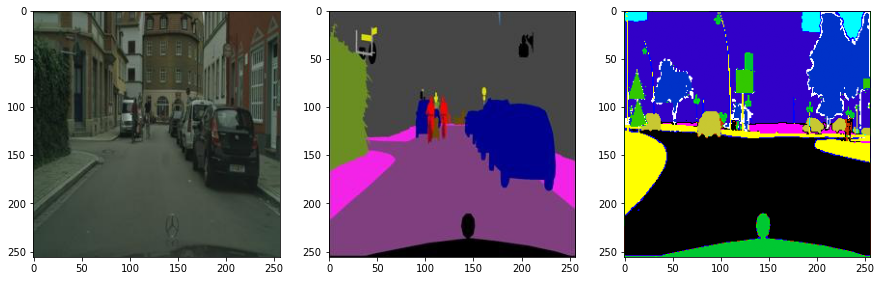

In [936]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
i = 100
axes[0].imshow(train_real[i])
axes[1].imshow(train_mask[i])
axes[2].imshow(train_label[i])

In [1215]:
val_real = []
val_mask = []
val_label = []
for i in range(len(val_fns)):
    sample_image = os.path.join(val_dir,val_fns[i])
    sample_image = Image.open(sample_image).convert("RGB")
    
    cityscape, label= divide_img(sample_image)
    val_real.insert(i,cityscape)
    val_mask.insert(i,label)
    cls = FindClassLoc(label)
    label = MaskOwnColor(cls)
    val_label.insert(i,label)

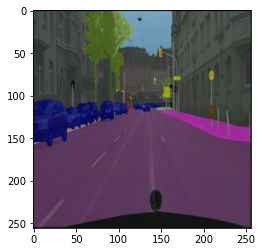

In [1219]:
total = cv2.addWeighted(train_real[3], 0.4, train_mask[3], 0.6, 0)
plot.imshow(total)

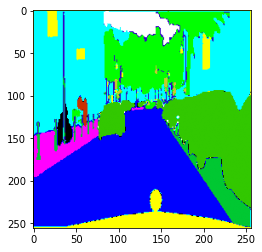

In [1222]:
plt.imshow(train_label[2])

In [610]:
path1 = "C:\\Users\\USER\\2020rne"
os.makedirs(path1+"/cityscape/train/image")
os.makedirs(path1+"/cityscape/train/mask")
os.makedirs(path1+"/cityscape/train/label")
os.makedirs(path1+"/cityscape/val/image")
os.makedirs(path1+"/cityscape/val/mask")
os.makedirs(path1+"/cityscape/val/label")

In [718]:
path = path1 + '/cityscape/'
for i in range(len(train_fns)):
    im_real = Image.fromarray(train_real[i])
    im_real.save(path+'train/image/' + str(i) +'.jpeg')
    im_mask = Image.fromarray(train_mask[i])
    im_mask.save(path+'train/mask/' + str(i) +'.jpeg')

In [719]:
for i in range(len(val_fns)):
    im_real = Image.fromarray(val_real[i])
    im_real.save(path+'val/image/' + str(i) +'.jpeg')
    im_mask = Image.fromarray(val_mask[i])
    im_mask.save(path+'val/mask/' + str(i) +'.jpeg')

In [820]:
train_real = np.array(train_real)
train_mask = np.array(train_mask)
val_real = np.array(val_real)
val_mask = np.array(val_mask)
print(train_real.shape)
print(train_mask.shape)
print(val_real.shape)
print(val_mask.shape)

(2975, 256, 256, 3)
(2975, 256, 256, 3)
(500, 256, 256, 3)
(500, 256, 256, 3)


-----------------------------------------------------------------

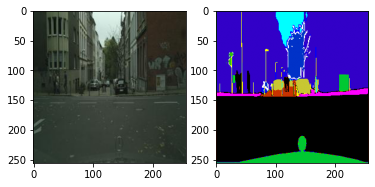

In [953]:
def Generate(path="C:\\Users\\USER\\kaggle\\cityscapes_data\\train", batch_size=10):
    
    files = os.listdir(path)
    while True:
        imgs=[]
        segs=[]
        
        for i in range(batch_size):         
            sample_image = os.path.join(train_dir,train_fns[i])
            sample_image = Image.open(sample_image).convert("RGB")
            img, seg = divide_img(sample_image)
            seg = FindClassLoc(seg)
            imgs.append(img)
            segs.append(seg)
        yield np.array(imgs), np.array(segs)
        
gen = Generate()
imgs, segs = next(gen)

plot.subplot(121)
plot.imshow(imgs[1])
plot.subplot(122)
plot.imshow(MaskOwnColor(segs[1]))
plot.show()